In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
pd.options.mode.chained_assignment = None
sns.set()

In [8]:
df = pd.read_csv("Hospital_data.csv")
df_covid = pd.read_csv('safe_data.csv', index_col='date', parse_dates=True)
state_covid = pd.read_csv('Wrangled_states.csv', index_col='date', parse_dates=True)

In [9]:
# Add new col to covid data for new_case_per_10000 for clearer regression results
df_covid['new_cases_per_10000'] = df_covid['new_cases'] / 10000
state_covid['new_cases_per_10000'] = state_covid['new_cases'] / 10000

In [10]:
df_covid.head()

,cases,deaths,new_cases,percent_change,new_cases_per_10000
date,,,,,
2020-01-21,1,0.0,1.0,1.0,0.0001
2020-01-22,1,0.0,0.0,0.0,0.0000
2020-01-23,1,0.0,0.0,0.0,0.0000
2020-01-24,2,0.0,1.0,1.0,0.0001
2020-01-25,3,0.0,1.0,0.5,0.0001


In [11]:
# Limit date range of covid data to match that of hospitalization data
df_covid = df_covid.loc['2020-07-25':'2021-11-26']
state_covid = state_covid.loc['2020-07-25':'2021-11-26']

In [12]:
# Split up state data
GU = state_covid.loc[state_covid.state=='Guam']
GA = state_covid.loc[state_covid.state=='Georgia']
RI = state_covid.loc[state_covid.state=='Rhode Island']
AK = state_covid.loc[state_covid.state=='Alaska']

In [13]:
# Resample covid data to match the weekly sampling of hospital data
df_covid = df_covid.resample(rule='W-FRI', convention='end').mean()
GU = GU.resample(rule='W-FRI', convention='end').mean()
GA = GA.resample(rule='W-FRI', convention='end').mean()
RI = RI.resample(rule='W-FRI', convention='end').mean()
AK = AK.resample(rule='W-FRI', convention='end').mean()

In [14]:
GU.shape, GA.shape, RI.shape, AK.shape

((70, 5), (70, 5), (70, 5), (70, 5))

## EDA and pre-processing of hospital data

Here I create two seperate data frames for the hospital data, one in long form with the hospital occupancy for each state listed by week, and anouther with he national rates of hospital occupancy.

In [15]:
df = df[['collection_week', 'state', 'inpatient_beds_7_day_avg', 'inpatient_beds_used_7_day_avg', 'inpatient_beds_used_covid_7_day_avg']]
df.replace(to_replace={-999999:0}, inplace=True)
df.fillna(value=0, inplace=True)
df.isna().sum()

collection_week                        0
state                                  0
inpatient_beds_7_day_avg               0
inpatient_beds_used_7_day_avg          0
inpatient_beds_used_covid_7_day_avg    0
dtype: int64

In [16]:
df = df.groupby(['collection_week', 'state']).sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3865 entries, ('2020-07-31', 'AK') to ('2021-11-26', 'WY')
Data columns (total 3 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   inpatient_beds_7_day_avg             3865 non-null   float64
 1   inpatient_beds_used_7_day_avg        3865 non-null   float64
 2   inpatient_beds_used_covid_7_day_avg  3865 non-null   float64
dtypes: float64(3)
memory usage: 99.2+ KB


In [17]:
df.reset_index(level='state', inplace=True)
df.index = pd.to_datetime(df.index)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3865 entries, 2020-07-31 to 2021-11-26
Data columns (total 4 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   state                                3865 non-null   object 
 1   inpatient_beds_7_day_avg             3865 non-null   float64
 2   inpatient_beds_used_7_day_avg        3865 non-null   float64
 3   inpatient_beds_used_covid_7_day_avg  3865 non-null   float64
dtypes: float64(3), object(1)
memory usage: 151.0+ KB


In [19]:
df['covid_ratio'] = df.inpatient_beds_used_covid_7_day_avg / df.inpatient_beds_7_day_avg
df['bed_ratio'] = df.inpatient_beds_used_7_day_avg / df.inpatient_beds_7_day_avg
df.fillna(value=0, inplace=True)

In [20]:
df.head()

,state,inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,inpatient_beds_used_covid_7_day_avg,covid_ratio,bed_ratio
collection_week,,,,,,
2020-07-31,AK,983.0,696.8,33.0,0.033571,0.708850
2020-07-31,AL,14741.0,10512.6,1879.2,0.127481,0.713154
2020-07-31,AR,7062.1,4628.1,1535.6,0.217442,0.655343
2020-07-31,AZ,8354.5,8561.2,1964.4,0.235131,1.024741
2020-07-31,CA,60201.6,42903.1,7462.9,0.123965,0.712657


In [21]:
df_state = df.pivot_table(index=df.index, columns=['state'], values=['bed_ratio'])
df_state.fillna(value=0, inplace=True)

df_state_covid_ratio = df.pivot_table(index=df.index, columns=['state'], values=['covid_ratio'])
df_state_covid_ratio.fillna(value=0, inplace=True)

df_state.head()

bed_ratio                                               \
state                  AK        AL        AR   AS        AZ        CA   
collection_week                                                          
2020-07-31       0.708850  0.713154  0.655343  0.0  1.024741  0.712657   
2020-08-07       0.512919  0.713215  0.643504  0.0  1.008795  0.706541   
2020-08-14       0.785965  0.715251  0.630255  0.0  0.931476  0.712135   
2020-08-21       0.752534  0.703054  0.634647  0.0  0.777835  0.704661   
2020-08-28       0.758399  0.700929  0.636261  0.0  0.771941  0.696477   

                                                         ...            \
state                  CO        CT        DC        DE  ...        TN   
collection_week                                          ...             
2020-07-31       0.610416  0.713130  0.776942  0.690939  ...  0.606774   
2020-08-07       0.617954  0.730206  0.788910  0.693148  ...  0.611405   
2020-08-14       0.604577  0.725313  0.818407  0.692878  ...  0.620290   
2020-08-21       0.612472  0.721778  0.809956  0.718360  ...  0.605819   
2020-08-28       0.596533  0.714151  0.808910  0.691518  ...  0.636669   

                                                                             \
state                  TX        UT        VA        VI        VT        WA   
collection_week                                                               
2020-07-31       0.704683  0.589859  0.668238  0.566026  0.633252  0.892258   
2020-08-07       0.721005  0.581349  0.619428  0.502660  0.626254  0.857507   
2020-08-14       0.726915  0.549231  0.592294  0.545745  0.615554  0.593136   
2020-08-21       0.711611  0.556881  0.597762  0.495213  0.595298  0.901999   
2020-08-28       0.710893  0.558277  0.624864  0.542553  0.541404  0.873273   

                                               
state                  WI        WV        WY  
collection_week                                
2020-07-31       0.590355  0.682374  0.372585  
2020-08-07       0.599322  0.692684  0.346953  
2020-08-14       0.603447  0.706079  0.366941  
2020-08-21       0.600146  0.676683  0.391117  
2020-08-28       0.594559  0.669281  0.344767  

[5 rows x 56 columns]

In [25]:
df_nation = df.groupby(df.index)[['inpatient_beds_used_7_day_avg', 'inpatient_beds_7_day_avg', 'inpatient_beds_used_covid_7_day_avg']].sum()

In [26]:
df_nation['bed_ratio'] = df_nation.inpatient_beds_used_7_day_avg / df_nation.inpatient_beds_7_day_avg
df_nation['covid_ratio'] = df_nation.inpatient_beds_used_covid_7_day_avg / df_nation.inpatient_beds_7_day_avg
df_nation.head()

,inpatient_beds_used_7_day_avg,inpatient_beds_7_day_avg,inpatient_beds_used_covid_7_day_avg,bed_ratio,covid_ratio
collection_week,,,,,
2020-07-31,458251.5,671837.4,60653.0,0.682087,0.090279
2020-08-07,462566.1,680179.2,56195.7,0.680065,0.082619
2020-08-14,465293.8,686438.1,49309.1,0.677838,0.071833
2020-08-21,470553.3,691446.4,44678.9,0.680535,0.064617
2020-08-28,468011.7,699524.4,39894.2,0.669043,0.057030


In [17]:
df_nation.sort_values(by='bed_ratio', ascending=False)

,inpatient_beds_used_7_day_avg,inpatient_beds_7_day_avg,bed_ratio
collection_week,,,
2021-09-10,542482.2,696448.8,0.778926
2021-09-17,537399.7,694553.6,0.773734
2021-08-27,537778.3,698488.3,0.769917
2021-08-20,536833.8,698996.2,0.768007
2021-09-24,532355.5,693274.8,0.767885
...,...,...,...
2020-08-07,462566.1,680179.2,0.680065
2020-08-14,465293.8,686438.1,0.677838
2020-10-23,500985.6,741250.6,0.675865


# Compare Hospitalization to New Cases on National Level

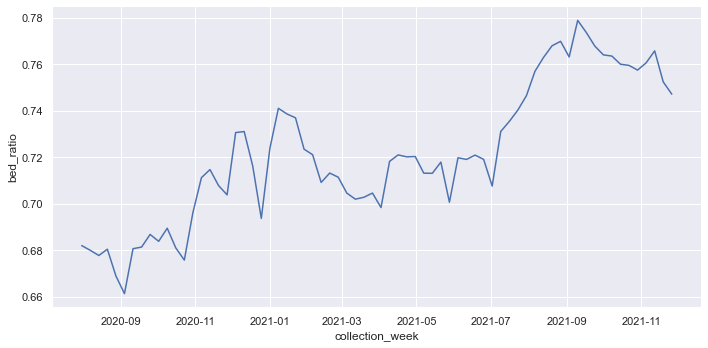

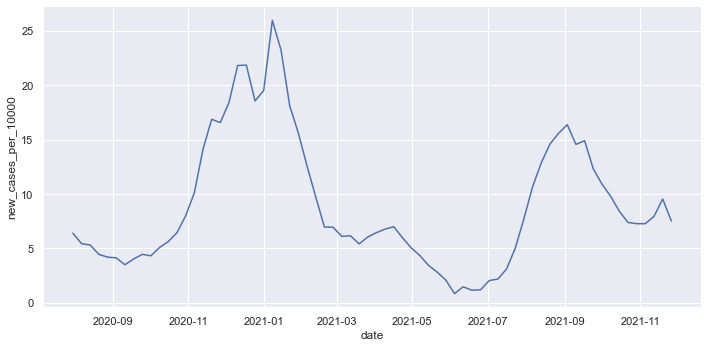

In [18]:
sns.relplot(kind='line', data=df_nation, x=df_nation.index, y='bed_ratio', aspect=2)
sns.relplot(kind='line', data=df_covid, x=df_covid.index, y='new_cases_per_10000', aspect=2)

In [19]:
# Define a function creating an OLS
def regression(x, y):
    exog = sm.add_constant(x, prepend=False)
    endog = y

    reg = sm.OLS(endog, exog)
    res = reg.fit()
    print(res.summary())
    return res


# Define a function plotting OLS results
def plot_ols(model, exog, endog):
    pred = model.predict()
    
    plt.figure(figsize=(8,5))
    plt.scatter(exog, endog)
    
    plt.xlabel('New Covid Cases in 10,000s')
    plt.ylabel('% Hospital beds filled')
    plt.plot(exog, pred)

C:\Users\blake\anaconda3\envs\capstone2_venv\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:              bed_ratio   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     12.27
Date:                Wed, 23 Mar 2022   Prob (F-statistic):           0.000820
Time:                        19:21:19   Log-Likelihood:                 152.74
No. Observations:                  70   AIC:                            -301.5
Df Residuals:                      68   BIC:                            -297.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
new_cases_per_10000     0.0019    

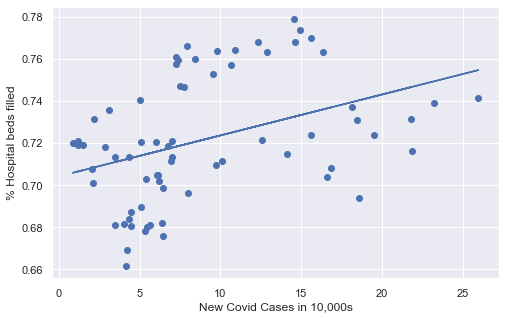

In [20]:
model = regression(df_covid.new_cases_per_10000, df_nation.bed_ratio)

plot_ols(model, df_covid.new_cases_per_10000, df_nation.bed_ratio)

## Now Look at Data by State

In [21]:
df_state.head()

bed_ratio                                               \
state                  AK        AL        AR   AS        AZ        CA   
collection_week                                                          
2020-07-31       0.708850  0.713154  0.655343  0.0  1.024741  0.712657   
2020-08-07       0.512919  0.713215  0.643504  0.0  1.008795  0.706541   
2020-08-14       0.785965  0.715251  0.630255  0.0  0.931476  0.712135   
2020-08-21       0.752534  0.703054  0.634647  0.0  0.777835  0.704661   
2020-08-28       0.758399  0.700929  0.636261  0.0  0.771941  0.696477   

                                                         ...            \
state                  CO        CT        DC        DE  ...        TN   
collection_week                                          ...             
2020-07-31       0.610416  0.713130  0.776942  0.690939  ...  0.606774   
2020-08-07       0.617954  0.730206  0.788910  0.693148  ...  0.611405   
2020-08-14       0.604577  0.725313  0.818407  0.692878  ...  0.620290   
2020-08-21       0.612472  0.721778  0.809956  0.718360  ...  0.605819   
2020-08-28       0.596533  0.714151  0.808910  0.691518  ...  0.636669   

                                                                             \
state                  TX        UT        VA        VI        VT        WA   
collection_week                                                               
2020-07-31       0.704683  0.589859  0.668238  0.566026  0.633252  0.892258   
2020-08-07       0.721005  0.581349  0.619428  0.502660  0.626254  0.857507   
2020-08-14       0.726915  0.549231  0.592294  0.545745  0.615554  0.593136   
2020-08-21       0.711611  0.556881  0.597762  0.495213  0.595298  0.901999   
2020-08-28       0.710893  0.558277  0.624864  0.542553  0.541404  0.873273   

                                               
state                  WI        WV        WY  
collection_week                                
2020-07-31       0.590355  0.682374  0.372585  
2020-08-07       0.599322  0.692684  0.346953  
2020-08-14       0.603447  0.706079  0.366941  
2020-08-21       0.600146  0.676683  0.391117  
2020-08-28       0.594559  0.669281  0.344767  

[5 rows x 56 columns]

In [22]:
top_10 = list(df_state.mean().sort_values(ascending=False).head(10).index)
top_10 = [i[1] for i in top_10]
top_10

['RI', 'MD', 'PA', 'DC', 'SC', 'GA', 'MA', 'CT', 'MI', 'NC']

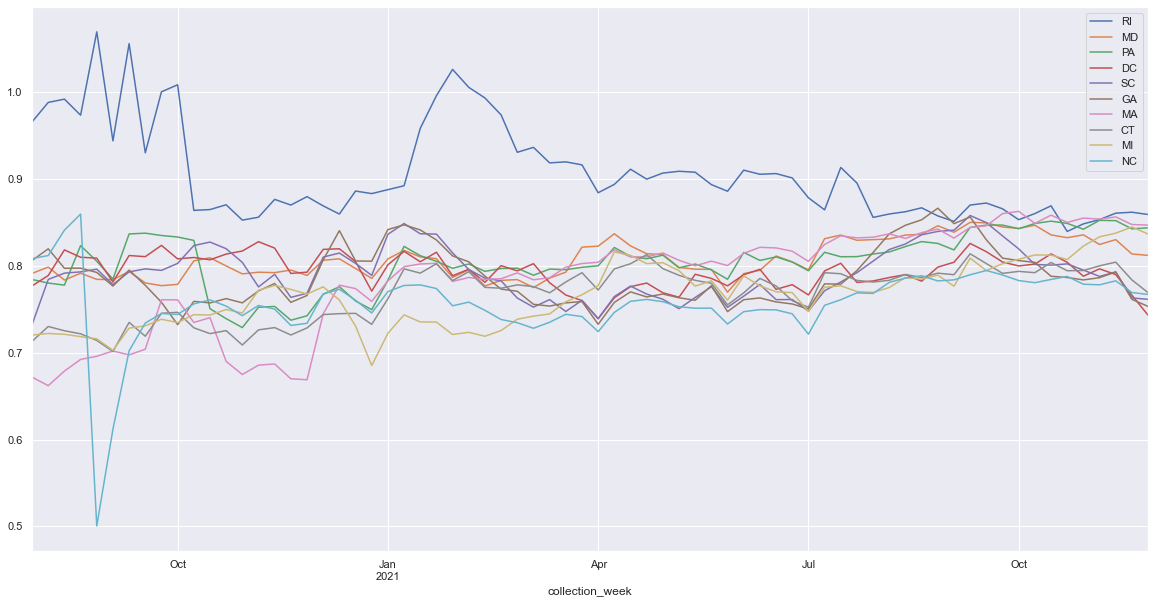

In [23]:
for i in top_10:
    df_state.loc[:, ('bed_ratio', i)].plot(figsize=(20,10), label=i)
plt.legend()

In [24]:
df_state.loc[:, ('bed_ratio', 'RI')].max()

1.06962097789992

In [25]:
max_10 = list(df_state.max().sort_values(ascending=False).head(10).index)
max_10 = [i[1] for i in max_10]

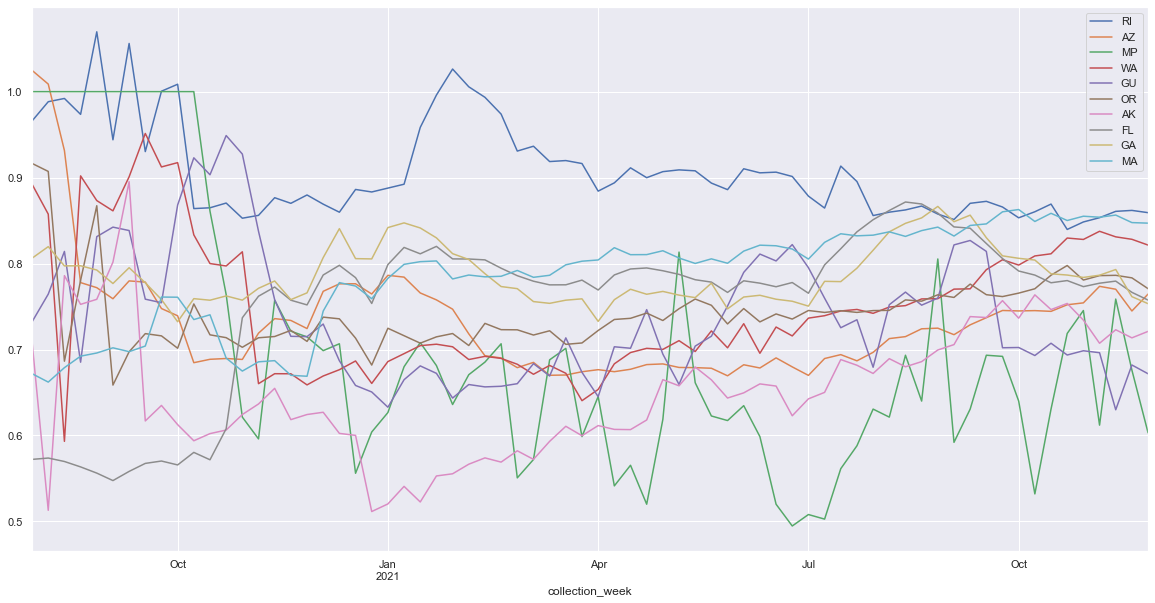

In [26]:
for i in max_10:
    df_state.loc[:, ('bed_ratio', i)].plot(figsize=(20,10), label=i)
plt.legend()

### Look at Rhode Island

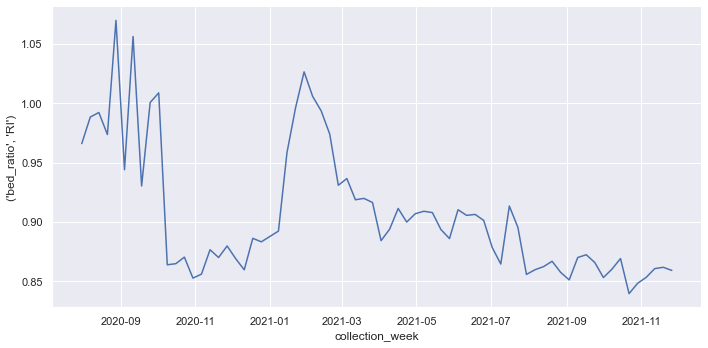

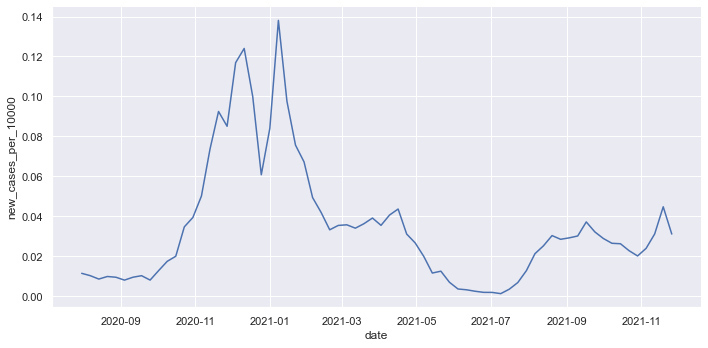

In [27]:
sns.relplot(kind='line', data=df_state.loc[:, ('bed_ratio', 'RI')], aspect=2)
sns.relplot(kind='line', data=RI, x=RI.index, y=RI.new_cases_per_10000, aspect=2)

                             OLS Regression Results                            
Dep. Variable:     ('bed_ratio', 'RI')   R-squared:                       0.017
Model:                             OLS   Adj. R-squared:                  0.002
Method:                  Least Squares   F-statistic:                     1.145
Date:                 Wed, 23 Mar 2022   Prob (F-statistic):              0.288
Time:                         19:21:21   Log-Likelihood:                 105.46
No. Observations:                   70   AIC:                            -206.9
Df Residuals:                       68   BIC:                            -202.4
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
new_cases_per_10000    -

C:\Users\blake\anaconda3\envs\capstone2_venv\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


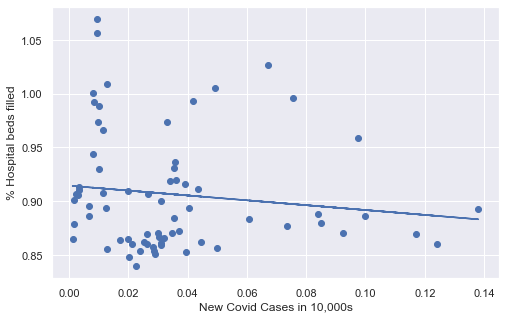

In [28]:
model = regression(RI.new_cases_per_10000, df_state.loc[:, ('bed_ratio', 'RI')])

plot_ols(model, RI.new_cases_per_10000, df_state.loc[:, ('bed_ratio', 'RI')])

### Look at Guam

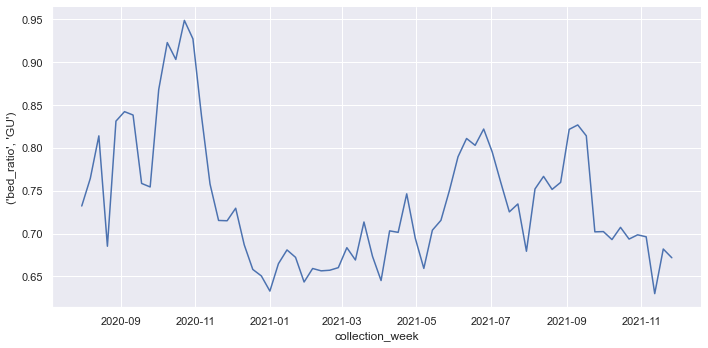

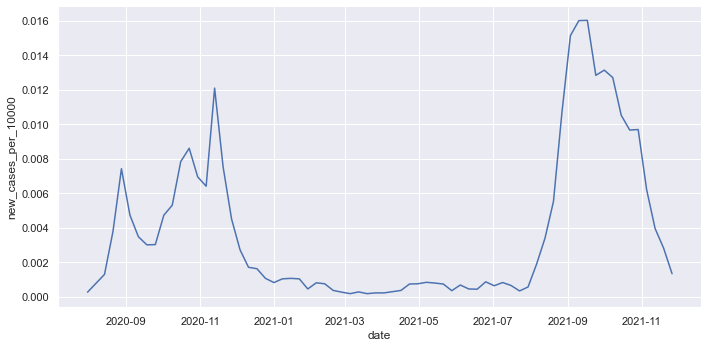

In [29]:
sns.relplot(kind='line', data=df_state.loc[:, ('bed_ratio', 'GU')], aspect=2)
sns.relplot(kind='line', data=GU, x=GU.index, y=GU.new_cases_per_10000, aspect=2)

                             OLS Regression Results                            
Dep. Variable:     ('bed_ratio', 'GU')   R-squared:                       0.123
Model:                             OLS   Adj. R-squared:                  0.110
Method:                  Least Squares   F-statistic:                     9.562
Date:                 Wed, 23 Mar 2022   Prob (F-statistic):            0.00288
Time:                         19:21:22   Log-Likelihood:                 86.262
No. Observations:                   70   AIC:                            -168.5
Df Residuals:                       68   BIC:                            -164.0
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
new_cases_per_10000     

C:\Users\blake\anaconda3\envs\capstone2_venv\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


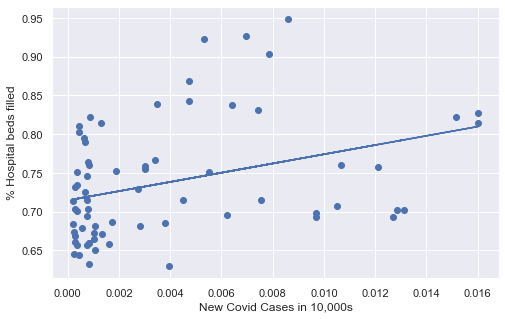

In [30]:
model = regression(GU.new_cases_per_10000, df_state.loc[:, ('bed_ratio', 'GU')])

plot_ols(model, GU.new_cases_per_10000, df_state.loc[:, ('bed_ratio', 'GU')])

### Now Look at Georgia

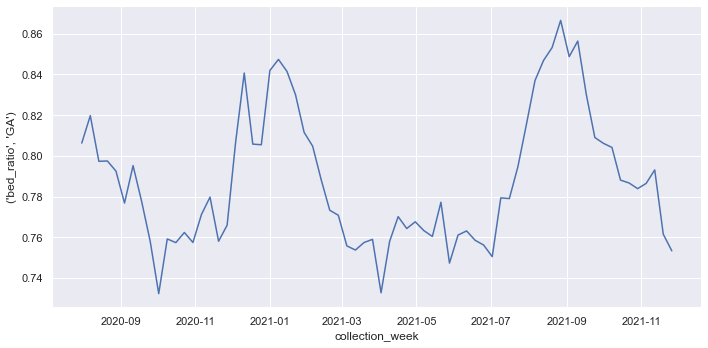

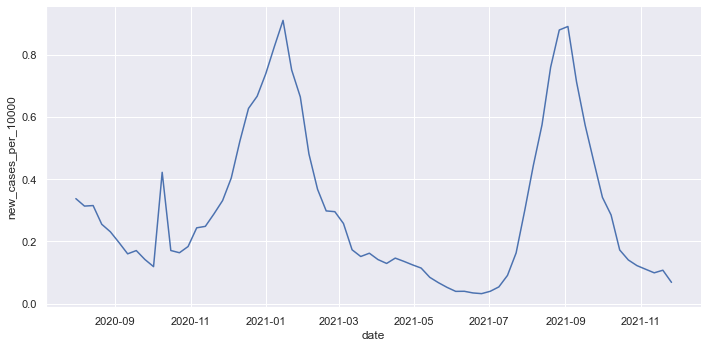

In [31]:
sns.relplot(kind='line', data=df_state.loc[:, ('bed_ratio', 'GA')], aspect=2)
sns.relplot(kind='line', data=GA, x=GA.index, y=GA.new_cases_per_10000, aspect=2)

                             OLS Regression Results                            
Dep. Variable:     ('bed_ratio', 'GA')   R-squared:                       0.715
Model:                             OLS   Adj. R-squared:                  0.710
Method:                  Least Squares   F-statistic:                     170.3
Date:                 Wed, 23 Mar 2022   Prob (F-statistic):           3.43e-20
Time:                         19:21:22   Log-Likelihood:                 184.23
No. Observations:                   70   AIC:                            -364.5
Df Residuals:                       68   BIC:                            -360.0
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
new_cases_per_10000     

C:\Users\blake\anaconda3\envs\capstone2_venv\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


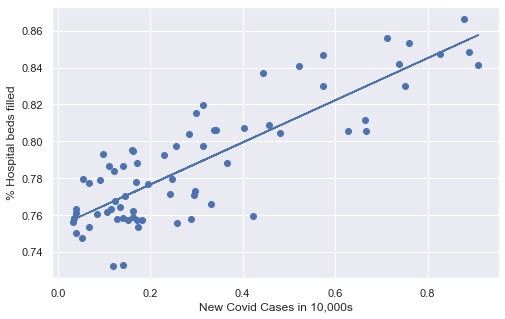

In [32]:
model = regression(GA.new_cases_per_10000, df_state.loc[:, ('bed_ratio', 'GA')])

plot_ols(model, GA.new_cases_per_10000, df_state.loc[:, ('bed_ratio', 'GA')])

### Now look at Alaska

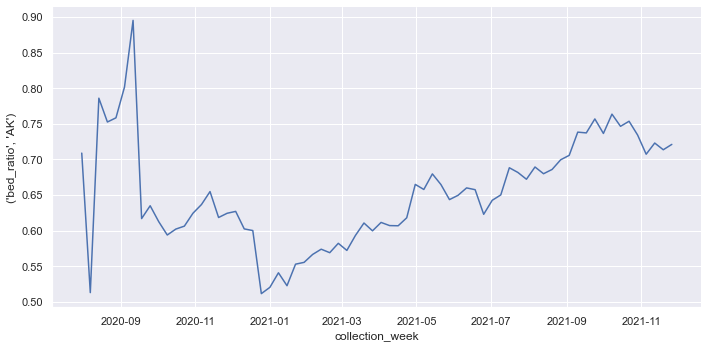

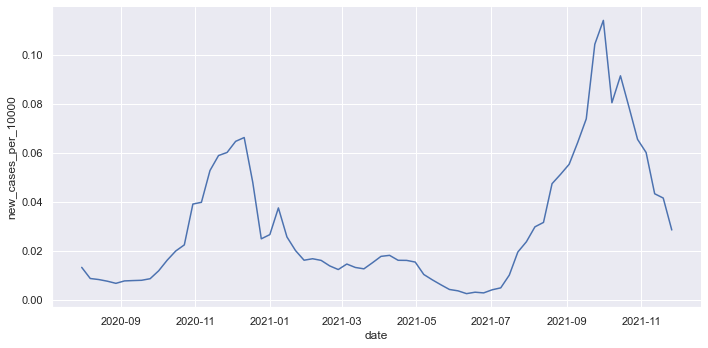

In [33]:
sns.relplot(kind='line', data=df_state.loc[:, ('bed_ratio', 'AK')], aspect=2)
sns.relplot(kind='line', data=AK, x=AK.index, y=AK.new_cases_per_10000, aspect=2)

                             OLS Regression Results                            
Dep. Variable:     ('bed_ratio', 'AK')   R-squared:                       0.096
Model:                             OLS   Adj. R-squared:                  0.083
Method:                  Least Squares   F-statistic:                     7.229
Date:                 Wed, 23 Mar 2022   Prob (F-statistic):            0.00901
Time:                         19:21:23   Log-Likelihood:                 85.325
No. Observations:                   70   AIC:                            -166.6
Df Residuals:                       68   BIC:                            -162.2
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
new_cases_per_10000     

C:\Users\blake\anaconda3\envs\capstone2_venv\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


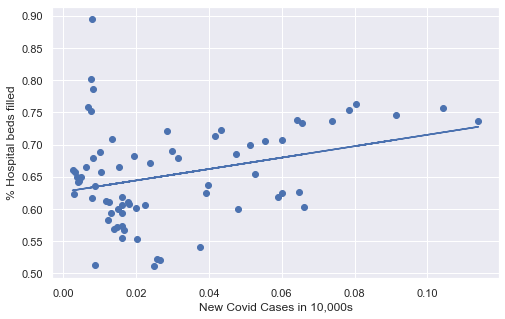

In [34]:
model = regression(AK.new_cases_per_10000, df_state.loc[:, ('bed_ratio', 'AK')])

plot_ols(model, AK.new_cases_per_10000, df_state.loc[:, ('bed_ratio', 'AK')])

In [39]:
df_state.to_csv('State_hospitalizations.csv')

In [27]:
df_nation.to_csv('Nation_hospitalizations.csv')

In [41]:
df_covid.to_csv('Covid_for_hospitals.csv')
GA.to_csv('GA_covid.csv')

In [22]:
df_state_covid_ratio.to_csv('Covid_bedRatio.csv')